---
---

# 1. Setup

---
---

### Imports

In [ ]:
import random
import os
import ast

from google.colab import drive

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import plotly as ply
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sn
import matplotlib.pyplot as plt
import umap

from scipy import stats

### Mount the drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/ca4015_assignment4/data")

---
---

# 2. Read in data

---
---

For the collaborative filtering (CF) system, the important data is the interaction between user and artist. Since all of our data is merged together, we split it into the needed dataframes:
- artists: contains detailed information for each artist, such as name, genres, and link to an image for them.  
- listening: Contains user-artist pairs with the amount of time each user has listened to the artist.  

##### Read in the full dataset

In [ ]:
df = pd.read_csv("processed_data/original_and_spotify_data (1).csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (4,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
df.sample(5)

,userID,artistID,artistWeight,friendID,artistName,tagID,timestamp,tagValue,spotifyName,imageUrl,genres,spotifyUrl
981588,757,701,169596.0,378.0,Shakira,2700.0,2010-11-30 23:00:00.000,best,Shakira,https://i.scdn.co/image/93e6b100a00437a05f57aa...,"['colombian pop', 'dance pop', 'latin', 'latin...",https://open.spotify.com/artist/0EmeFodog0BfCg...
1809217,359,6064,448.0,643.0,Nena,16.0,2006-07-31 22:00:00.000,new wave,Nena,https://i.scdn.co/image/3dc7f7f65c39a37380bfd7...,"['german pop', 'german rock', 'new wave pop']",https://open.spotify.com/artist/6Tz0QRoe083BcO...
1946076,761,9863,260.0,1054.0,Tones on Tail,NaN,NaN,NaN,Tones On Tail,https://i.scdn.co/image/ab67616d0000b273768d2a...,"['dance rock', 'dark wave', 'gothic rock', 'in...",https://open.spotify.com/artist/5aBEGOeWQCJfpt...
1924721,949,8684,1033.0,203.0,Broadway,NaN,NaN,NaN,Newsies Original Broadway Cast,NaN,"['broadway', 'show tunes']",https://open.spotify.com/artist/6yTc5YHDriVSWY...
2106215,1745,9943,453.0,249.0,Vanna,NaN,NaN,NaN,Vanna,https://i.scdn.co/image/b3532e54ad75d18b7951cb...,"['melodic hardcore', 'melodic metalcore', 'met...",https://open.spotify.com/artist/7cXUCar1BPOeMI...


##### Get the artists columns

In [ ]:
artists = df[["artistID", "artistName", "imageUrl", "spotifyUrl", "genres"]] \
.drop_duplicates().dropna(subset=["artistName"]) \
.sort_values("artistID").reset_index(drop=True)

artists["genres"] = artists["genres"].apply(ast.literal_eval)
artists["genre"] = artists["genres"].apply(lambda x: x[0] if len(x) > 0 else None)
artists

,artistID,artistName,imageUrl,spotifyUrl,genres,genre
0,1,MALICE MIZER,NaN,NaN,[],None
1,2,Diary of Dreams,https://i.scdn.co/image/d1541238b711b8ca7aca43...,https://open.spotify.com/artist/1tg5jMp8FFjVqj...,"[dark wave, ebm, electro-industrial, ethereal ...",dark wave
2,3,Carpathian Forest,https://i.scdn.co/image/ab67616d0000b273e5e56d...,https://open.spotify.com/artist/0sFntmE9T1tiF6...,"[black metal, dark black metal, metal, norwegi...",black metal
3,4,Moi dix Mois,NaN,NaN,[],None
4,5,Bella Morte,https://i.scdn.co/image/24df6d7abf75759f89bda2...,https://open.spotify.com/artist/2SyimynlSU0Oii...,"[dark wave, ethereal wave, gothic rock]",dark wave
...,...,...,...,...,...,...
17627,18741,Diamanda Galás,https://i.scdn.co/image/9af3e7aeaf26ad28166111...,https://open.spotify.com/artist/42AURgCa94xz79...,"[experimental, experimental vocal, industrial,...",experimental
17628,18742,Aya RL,https://i.scdn.co/image/ab67616d0000b27327c22a...,https://open.spotify.com/artist/3qZ0S1nVG3Pcct...,"[polish post-punk, polish punk, polish rock]",polish post-punk
17629,18743,Coptic Rain,https://i.scdn.co/image/ab67616d0000b273a980dc...,https://open.spotify.com/artist/3GrTeFVsVk1fKB...,[],None
17630,18744,Oz Alchemist,https://i.scdn.co/image/0b62352c054083afecc922...,https://open.spotify.com/artist/7tt8Fc1yW2t9SC...,[],None


##### Get the listening columns

In [ ]:
listening = df[["userID", "artistID", "artistWeight"]].drop_duplicates().dropna().astype(int).sort_values(["userID", "artistID"]).reset_index(drop=True)
listening

,userID,artistID,artistWeight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [ ]:
num_users = listening["userID"].max() + 1
num_artists = listening["artistID"].max() + 1

print("Number of unique users:", num_users)
print("Number of unique artists:", num_artists)
print(f"Data density: {len(listening) / (num_users * num_artists):.2%}")

Number of unique users: 2101
Number of unique artists: 18746
Data density: 0.24%


---
---
# 3. Building the Training Dataset
---
---

To train our CF model, we need to manipulate the data we have a bit. Currenttly, we have our data in long format, with each row representing a user-artist pair. We need to convert this into a wide format where each row represents a user, and each column an artist. The values in each cell will be the listening time.  
The data is extremely sparse, with less than a quarter of a percent of the possible user-artist pairs existing. If we stored this normally in wide format, we would have to store every single combination with the majority having a value of 0. To make this more efficient, we use a SparseTensor from the Tensorflow library. This stores the data in long format, but lets us do matrix operations as if it was in wide format by assuming that any pair not in the data has a value of 0.

In [ ]:
def split_users(df, split=0.7):
    users = df["userID"].unique()

    train_users, test_users = train_test_split(users, train_size=split)

    return df[df["userID"].isin(train_users)], df[~df["userID"].isin(train_users)]

In [ ]:
def build_sparse(df, idx_cols, val_col):
    return tf.SparseTensor(df[idx_cols].values,
                          df[val_col].values,
                          tuple(df[c].max() + 1 for c in idx_cols) 
                          )

In [ ]:
listening_tensor = build_sparse(listening, ["userID", "artistID"], "artistWeight")

In [ ]:
print("Shape of sparse tensor:", listening_tensor.shape.as_list())
print("Number of values stored:", listening_tensor.values.shape.as_list())

Shape of sparse tensor: [2101, 18746]
Number of values stored: [92834]


In [ ]:
# Normalise by user, 1=most listened to artist
listening_tensor /= tf.sparse.reduce_max(listening_tensor, axis=1, keepdims=True)

---
---
# 4. User and Artist Embeddings
---
---

The CF model learns to create two sets of embeddings from our sparse data; one for users and one for artists. 

In [ ]:
def create_embeddings(sparse_data: tf.SparseTensor, embedding_dim=8, init="zeros"):
  
    # How to initialise the embedding values
    if init == "zeros":
        vals = tf.zeros_initializer()

    elif init == "random":
        vals = tf.random_normal_initializer()

    embeddings = []
    for data_dim in sparse_data.shape:
        embeddings.append(tf.Variable(vals([data_dim, embedding_dim]), trainable=True))

    return embeddings

In [ ]:
#@title Initalise the embeddings
embedding_size = 7 #@param {type:"slider", min:1, max:100, step:1}
embedding_init = "random" #@param ["random", "zeros"]

user_embedding, artist_embedding = create_embeddings(listening_tensor, embedding_size, embedding_init)

print("User embedding shape:", user_embedding.shape.as_list())
print("Artist embedding shape:", artist_embedding.shape.as_list())

User embedding shape: [2101, 8]
Artist embedding shape: [18746, 8]


---
---
# 5. Matrix Factorisation
---
---

Matrix factorisation works by trying to learn the two smaller matrices that a larger matrix decomposes into. In our case we are trying to decompose our sparse data matrix $S$ into two embedding matrices $U$ and $A$ such that:

$$S = UA^T$$

To do that, we minimise the squared error between our re-composed matrix $UA^T$ and our ground truth matrix $S$:

$$\underset{U, A}{argmin} \sum (S - UA^T)^{\circ 2}$$

In [ ]:
def mse_loss(sparse_data: tf.SparseTensor, embeddings):
    # Mean squared error
    logits = tf.gather(embeddings[0], sparse_data.indices[:, 0])
    for i in range(1, len(embeddings)):
        logits *= tf.gather(embeddings[i], sparse_data.indices[:, i])

    predictions = tf.reduce_sum(logits, axis=1)

    loss = tf.losses.mean_squared_error(sparse_data.values, predictions)

    return loss

In [ ]:
def train_step(sparse_data: tf.SparseTensor, embeddings: list, optimiser: tf.optimizers.Optimizer):
    # Compute the loss
    with tf.GradientTape() as t:
       loss = mse_loss(sparse_data, embeddings)

    # Compute gradient
    grads = t.gradient(loss, embeddings)
    
    # Update embeddings
    optimiser.apply_gradients(zip(grads, embeddings))

    return loss.numpy()

In [ ]:
#@title Train the CF model
epochs =  1000#@param {type:"integer"}

opt = tf.optimizers.Adam(learning_rate=0.001)
losses = []
for i in range(epochs):
  loss = train_step(listening_tensor, [user_embedding, artist_embedding], opt)
  losses.append(loss)

  print("\r", i + 1, "/", epochs, "loss:", loss, end="", flush=True)

 1000 / 1000 loss: 0.009802196

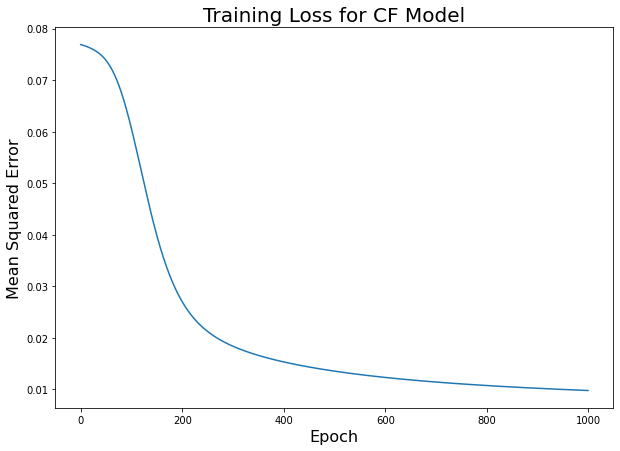

In [ ]:
plt.subplots(figsize=(10, 7))
plt.plot(losses)
plt.title("Training Loss for CF Model", fontsize=20)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.show()

---
---
# 6. Generating Recommendations
---
---

Unfortunately, the collaborative filtering approach does not allow for new inputs to the system, as it must have built embeddings for both user and artist. However, we can generate recommendations for users of songs they have not listened to before.  

### Prepare artist genres

In [ ]:
def random_colour():
    return "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])

In [ ]:
# Assign colours to each genre
unique_genres = artists["genre"].unique()
colours  = [random_colour() for _ in range(len(unique_genres))]

genre_colours = pd.DataFrame({
    "genre": unique_genres,
    "colour": colours
})

genre_colours

,genre,colour
0,None,#582824
1,dark wave,#34A183
2,black metal,#CE7D9E
3,gothic black metal,#D22F7D
4,alternative metal,#746876
...,...,...
2044,armenian folk,#27B755
2045,kurdish pop,#594B80
2046,musica tradicional cubana,#8C2AFE
2047,jazz boom bap,#ABBA0D


### Configure the predictions & the plotting

In [ ]:
# Template for plotting
template = dict(
  layout=go.Layout(
    xaxis=dict(zeroline=False),
    yaxis=dict(zeroline=False),
    title=dict(
      x=0.5,
      xanchor="center"
    )
  )
)

In [ ]:
def predict(query, target_embedding):
    logits = tf.reduce_sum(query * target_embedding, axis=1)
    return logits.numpy()

In [ ]:
def get_artists(predictions: np.ndarray, top=10):
    top_idx = predictions.argsort()[::-1][:top]

    top_artists = artists.set_index("artistID").loc[top_idx, "artistName"]

    return np.asarray(top_artists.index), top_artists.values, predictions[top_idx]

In [ ]:
def plot_artists(ids, names, scores):
  genres = artists.set_index("artistID").loc[ids, "genre"].tolist()
  colours = genre_colours.set_index("genre").loc[genres, "colour"].tolist()


  data = pd.DataFrame({"name": names, "weight": scores, "color": colours, "genre": genres, "id": ids})
  fig = go.Figure(go.Bar(dict(
    x=data["name"],
    y=data["weight"],
    marker=dict(
        color=data["color"]
    ),
    hovertemplate=(
      "Artist: %{x}<br>"
      "ID: %{text[1]}<br>"
      "Genre: %{text[0]}<br>"
      "Predicted value: %{y:,.3f} <br>"
    ),
    text=data[["genre", "id"]].fillna("N/A"),
    name=""
  )), layout=dict(
      template=template,
      yaxis=dict(title="Predicted Value", zeroline=True),
      title=dict(text="Artist Recommendations for the Given User"),
  ))

  fig.show()

### Demo

To generate recommendations, pick a user with the slider and run the cell.

In [ ]:
user_idx = 1891 #@param {type:"slider", min:0, max:1891, step:1}
user_id = sorted(listening["userID"].unique())[user_idx]

preds = predict(user_embedding[user_id], artist_embedding)
ids, names, weights = get_artists(preds, top=50)
plot_artists(ids, names, weights)

---
---
# 7. Visualising Embeddings
---
---

To better understand the embeddings created by the matrix factorisation, we can visualise them at two dimensions. To do this, we use [UMAP](https://arxiv.org/abs/1802.03426), which is similar to Principal Component Analysis (PCA) in that it reduces the dimensions of data. However, while PCA does this in a linear way, UMAP is non-linear and aims to preserve both local and global structures in the data. This can be thought of as creating an embedding for the embeddings.

In [ ]:
umap_user_embeddings = umap.UMAP(metric="cosine").fit_transform(user_embedding.numpy())
umap_artist_embeddings = umap.UMAP(metric="cosine").fit_transform(artist_embedding.numpy())

### User Embeddings

In [ ]:
users_top3 = []
artists_name = artists.set_index("artistID")["artistName"]
for user, df in listening.groupby("userID"):
  # Get top 3 artist ids for each user
  top3 = df.sort_values("artistID", ascending=False)["artistID"].head(3).tolist()

  users_top3.append({
      "userID": user,
      "artistIDs": top3,
      "artist_names": artists_name.loc[top3].tolist()
  })

users_top3 = pd.DataFrame(users_top3)
users_top3["artist_names"] = users_top3["artist_names"].apply("<br>".join) # HTML list
# users_top3

In [ ]:
go.Figure(go.Scatter(dict(
    x=umap_user_embeddings[users_top3.index, 0],
    y=umap_user_embeddings[users_top3.index, 1],
    mode="markers",
    text=users_top3,
    hovertemplate=(
        "User ID: %{text[0]}<br>"
        "Likes:<br>%{text[2]}<br>"
    ),
    name="",
)), layout=dict(
  template=template,
  width=800,
  height=800,
  xaxis=dict(title="UMAP Dimension 0"),
  yaxis=dict(title="UMAP Dimension 1", scaleanchor="x", scaleratio=1),
  title=dict(text="User Embeddings with UMAP"),
  hovermode="closest"
))

### Artist Embeddings

**NOTE**: The plot for artists has a lot of datapoints and can be very laggy, clear the cell output if interaction becomes too slow.

In [ ]:
artist_genres_top3 = artists["genres"].apply(lambda l: "<br>".join(l[:3]))
data = pd.DataFrame({
    "artistID": artists["artistID"].tolist(),
    "artistName": artists["artistName"].tolist(),
    "genres": artist_genres_top3,
    "colour": genre_colours.set_index("genre").loc[artists["genre"], "colour"].tolist()
})

go.Figure(go.Scatter(dict(
    x=umap_artist_embeddings[artists["artistID"], 0],
    y=umap_artist_embeddings[artists["artistID"], 1],
    mode="markers",
    marker_color=data["colour"],
    text=data,
    hovertemplate=(
        "Name: %{text[1]}<br>"
        "Artist ID: %{text[0]}<br>"
        "Genres:<br>%{text[2]}<br>"
    ),
    name="",
)), layout=dict(
  template=template,
  width=800,
  height=800,
  xaxis=dict(title="UMAP Dimension 0"),
  yaxis=dict(title="UMAP Dimension 1", scaleanchor="x", scaleratio=1),
  title=dict(text="Artist Embeddings with UMAP"),
  hovermode="closest"
)).show(renderer="colab")